In [2]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, f_regression

In [3]:
# Read target chemical properties and extracted descriptors. (Descriptors were extracted using mordred library)
df = pd.read_csv('mordred_descriptors.csv',header = 0)
print(df)

       Unnamed: 0      Name        SA        PV        CL        ABC  \
0               0  0001_A_L     0.000  0.000000  0.000007  99.138348   
1               1  0001_A_S     0.000  0.000000  0.000007  93.919053   
2               2  0001_C_L     0.000  0.000000  0.000007  90.653067   
3               3  0001_C_S   163.054  0.036695  0.000007  85.433772   
4               4  0002_A_L     0.000  0.000000  0.000008  82.491306   
...           ...       ...       ...       ...       ...        ...   
10232       10939  4949_A_S     0.000  0.000000  0.000012  62.416518   
10233       10940  4950_A_L  2402.710  0.764515  0.000013  36.523114   
10234       10941  4950_A_S  3105.978  0.981101  0.000015  31.303819   
10235       10942  4950_C_L  2809.634  0.783252  0.000017  28.037833   
10236       10943  4950_C_S  2447.508  0.754277  0.000023  22.818538   

           ABCGG  nAcid  nBase     SpAbs_A  ...      SRW10      TSRW10  \
0      53.343158    0.0    0.0  166.064151  ...  11.887801  1

In [4]:
# Post processing : Take only descriptors that are not null

Feature_Names = df.columns

not_null = [Feature_Names[0]]

for item in Feature_Names:
    missing = df[item].isnull().sum()
    if missing > 0:
        not_null.append(item) 


df_not_null = df.drop(not_null, axis=1)
print(df_not_null)

           Name        SA        PV        CL        ABC      ABCGG  nAcid  \
0      0001_A_L     0.000  0.000000  0.000007  99.138348  53.343158    0.0   
1      0001_A_S     0.000  0.000000  0.000007  93.919053  50.296336    0.0   
2      0001_C_L     0.000  0.000000  0.000007  90.653067  51.069390    0.0   
3      0001_C_S   163.054  0.036695  0.000007  85.433772  47.951685    0.0   
4      0002_A_L     0.000  0.000000  0.000008  82.491306  49.718551    0.0   
...         ...       ...       ...       ...        ...        ...    ...   
10232  4949_A_S     0.000  0.000000  0.000012  62.416518  34.290241    0.0   
10233  4950_A_L  2402.710  0.764515  0.000013  36.523114  24.693094    0.0   
10234  4950_A_S  3105.978  0.981101  0.000015  31.303819  22.100564    0.0   
10235  4950_C_L  2809.634  0.783252  0.000017  28.037833  21.017221    0.0   
10236  4950_C_S  2447.508  0.754277  0.000023  22.818538  18.073559    0.0   

       nBase  nAromAtom  nAromBond  ...  SRW09      SRW10      

In [5]:
# Extract target property (Surface area) and chemical descriptors from dataframe

Y_SA = df_not_null.iloc[:,1]
X = df_not_null.iloc[:,4:].to_numpy()
Feature_Names = df_not_null.columns[4:]

print(Feature_Names)

Index(['ABC', 'ABCGG', 'nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nAtom',
       'nHeavyAtom', 'nSpiro', 'nBridgehead',
       ...
       'SRW09', 'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1',
       'Zagreb2', 'mZagreb2'],
      dtype='object', length=1125)


In [6]:
# Split train/test dataset

x_train, x_test, y_train, y_test = train_test_split(X, Y_SA, test_size = 0.2, shuffle = True, random_state = 42)
print(f'train data : {len(x_train)}, test data : {len(x_test)}')

train data : 8189, test data : 2048


In [7]:
# Post processing : Feature selection using variance threshold

sel = VarianceThreshold(0.5)
sel.fit(x_train)
x_train_var= sel.transform(x_train)
x_test_var = sel.transform(x_test)

cols = sel.get_support(indices=True)

Feature_Names_var = Feature_Names[cols]

Num Features:  45
Selected Features:  Index(['ABC', 'ABCGG', 'nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nAtom',
       'nHeavyAtom', 'nSpiro', 'nBridgehead',
       ...
       'SRW09', 'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1',
       'Zagreb2', 'mZagreb2'],
      dtype='object', length=1125)
[1, 45, 145, 245, 345, 445, 545]


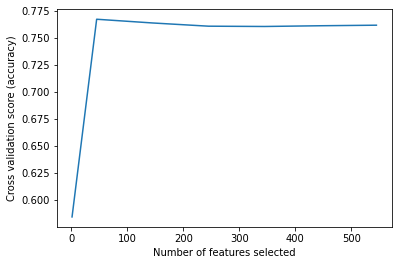

In [10]:
# Select optimal feature set using Recursive Feature Elimination with Cross Validation

estimator = RandomForestRegressor(random_state=42)
max_feature_num = len(Feature_Names_var)
step = 100 # hyper parameter

selector = RFECV(estimator, step = step, cv = 5, n_jobs=-1)
selector.fit(x_train_var,y_train)

x_train_selected = selector.transform(x_train_var)
x_test_selected = selector.transform(x_test_var)

cols = selector.get_support(indices=True)
Feature_Names_var = Feature_Names_var[cols]

print("Num Features: ", selector.n_features_)
print("Selected Features: ", Feature_Names)

result = selector.grid_scores_

num_features = [i for i in range(max_feature_num,1,step*-1)]

if num_features[-1] != 1:
    num_features.append(1)

num_features.reverse()

print(num_features)

plt.figure()

plt.plot(
    num_features,
    result,
)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")

plt.show()

In [11]:
# Train Random Forest Model using Grid Search Cross Validation
# Grid search could take long time. Narrow down the search space if necessary

import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size']=18

params = { 'n_estimators' :  [500, 2500, 5000],
           'max_depth' : [None,4,8,16],
           #'max_features' : ['auto'],
           'min_samples_leaf' : [1,2,4],
           'min_samples_split' : [2,5,10],
            }

rf_clf = RandomForestRegressor(random_state = 42,n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 5,n_jobs=-1)
grid_cv.fit(x_train_selected, y_train)

print('Best hyper-parameter set: ', grid_cv.best_params_)

/home/parkjunkil/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyper-parameter set:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5000}
Best score: 0.7750


In [14]:
# Compute R2 score and MAE

from sklearn.metrics import r2_score
best_model = grid_cv.best_estimator_

y_train_pred = best_model.predict(x_train_selected)
y_test_pred = best_model.predict(x_test_selected)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print('R2 Score - Train : %.3f, Test : %3f' %(r2_train, r2_test))


train_error = [abs(a - b) for a, b in zip(y_train, y_train_pred)]
train_mae = sum(train_error) / len(y_train)

test_error = [abs(a - b) for a, b in zip(y_test, y_test_pred)]
test_mae = sum(test_error) / len(y_test)

print('MAE - Train : %.3f, Test : %3f' %(train_mae, test_mae))


R2 Score - Train : 0.971, Test : 0.782958
MAE - Train : 97.634, Test : 283.333890


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


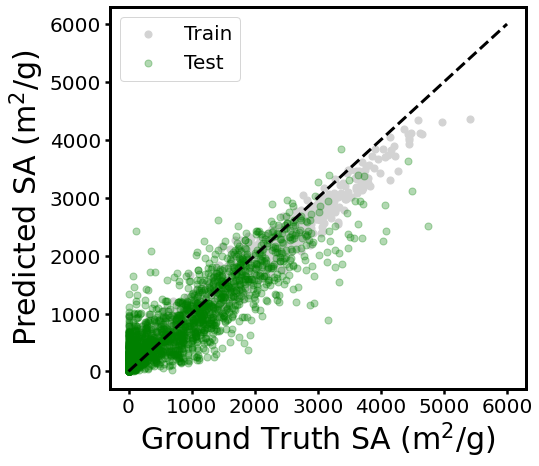

In [22]:
# Plot parity plot

import matplotlib.pyplot as plt

import matplotlib as mpl


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.axisbelow'] = True
#plt.rc('xtick', labelsize=24)
#plt.rc('ytick', labelsize=24)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2.5
mpl.rcParams['axes.linewidth'] = 3
plt.rcParams['font.size']=24

plt.figure(figsize=(8,7))

plt.scatter(y_train,y_train_pred,c='lightgray',marker='o', label='Train', s = 50)
plt.scatter(y_test,y_test_pred,c='green',alpha=0.3, marker='o', label='Test', s = 50)

a = np.linspace(0,6000)
plt.plot(a,a,c='black',linestyle='dashed',linewidth=3)

plt.ylabel('Predicted SA (m$^2$/g)', fontsize = 30)
plt.xlabel('Ground Truth SA (m$^2$/g)', fontsize = 30)
plt.legend(prop={'size': 20})

plt.xticks([0,1000,2000,3000,4000,5000,6000], fontsize = 20)
plt.yticks([0,1000,2000,3000,4000,5000,6000], fontsize = 20)

plt.tight_layout()

plt.savefig('RF_SA.svg', dpi=500, format = 'svg')


[0.01202128 0.01230782 0.01320877 0.01337405 0.01424459 0.0159025
 0.01637641 0.01814139 0.0189127  0.01910767 0.0193304  0.0224844
 0.0408255  0.1129871  0.36575137]


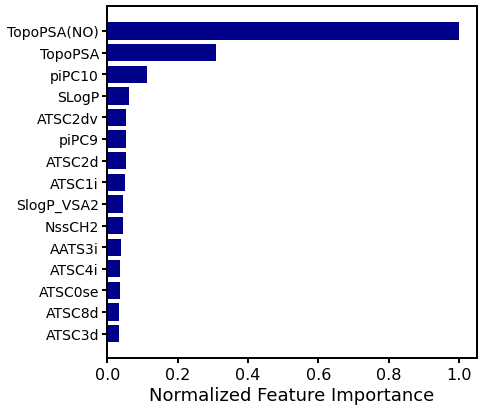

In [26]:
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size']=16

plt.figure(figsize=(7, 6))

saved_model = best_model

featureImportance = saved_model.feature_importances_

sorted_idx = np.argsort(featureImportance)[-15:]
print(featureImportance[sorted_idx])
FI  = featureImportance[sorted_idx]
max_fi = np.max(FI)
FI = FI/max_fi

barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, FI, align='center', color='darkblue')

plt.yticks(barPos, Feature_Names_var[sorted_idx], fontsize=14)

plt.xlabel('Normalized Feature Importance', fontsize=18)

plt.tight_layout()

plt.savefig('RF_SA_FI.svg', dpi=500, format = 'svg')